#### Import Libraries
We are importing necessary libraries for data manipulation, visualization, and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, mean_squared_error,
                             mean_absolute_error, f1_score,
                             r2_score, precision_recall_curve, roc_curve, auc)
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from collections import OrderedDict


#### Loading the Dataset
We load the flight delay dataset from a CSV file using `pandas`. The dataset is stored in the `CSV` folder and contains flight-related information for delay prediction.


In [2]:
data = pd.read_csv('../CSV/full_data_flightdelay.csv')

#### Sampling the Dataset
We randomly select a sample of 500,000 rows from the dataset to reduce the size for faster processing. The `random_state=42` ensures reproducibility, and we reset the index to maintain sequential indexing after sampling.


In [3]:
data = data.sample(n = 500_000, random_state = 42).reset_index(drop = True)

#### Preview the Dataset
We display the first 5 rows of the dataset using `head()`. This helps us quickly inspect the data and understand the structure and content of the columns.

In [4]:
data.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,3,5,0,1500-1559,3,4,27,69,"Midwest Airline, Inc.",11965,...,11,Ronald Reagan Washington National,38.852,-77.037,Eppley Airfield,0.00,0.0,0.0,68.0,4.47
1,9,7,0,2200-2259,5,1,7,128,American Airlines Inc.,6740,...,6,Miami International,25.792,-80.286,NONE,0.00,0.0,0.0,94.0,5.82
2,12,1,0,1900-1959,3,5,15,76,Endeavor Air Inc.,5359,...,5,Raleigh-Durham International,35.875,-78.782,Tampa International,0.00,0.0,0.0,50.0,7.83
3,8,3,0,1700-1759,6,2,22,276,United Air Lines Inc.,11012,...,17,Newark Liberty International,40.696,-74.172,San Francisco International,1.69,0.0,0.0,84.0,4.25
4,9,5,0,0800-0859,2,1,3,76,Mesa Airlines Inc.,1378,...,2,Tulsa International,36.198,-95.890,NONE,0.00,0.0,0.0,95.0,6.26


#### Checking for Missing Values
We use `isnull().sum()` to count the number of missing values in each column. This helps identify any incomplete data that may need to be handled before model training.

In [5]:
data.isnull().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

#### Selecting Relevant Columns and Previewing the Data
We select a subset of relevant columns from the dataset that include flight schedule details (e.g., 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK'), distance and segment information, flight conditions, weather data (e.g., 'PRCP', 'SNOW', 'TMAX'), and airport/airline statistics. These features are critical for building predictive models.

After selecting the columns, we display the first 5 rows to confirm the structure of the filtered dataset.


In [6]:
columns = [
    'MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
    'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'CARRIER_NAME',
    'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH',
    'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
    'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT',
    'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'
]
data = data[columns]

data.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,3,5,0,1500-1559,3,4,27,69,"Midwest Airline, Inc.",11965,...,0.000001,0.000124,11,Ronald Reagan Washington National,Eppley Airfield,0.00,0.0,0.0,68.0,4.47
1,9,7,0,2200-2259,5,1,7,128,American Airlines Inc.,6740,...,0.000098,0.000177,6,Miami International,NONE,0.00,0.0,0.0,94.0,5.82
2,12,1,0,1900-1959,3,5,15,76,Endeavor Air Inc.,5359,...,0.000000,0.000094,5,Raleigh-Durham International,Tampa International,0.00,0.0,0.0,50.0,7.83
3,8,3,0,1700-1759,6,2,22,276,United Air Lines Inc.,11012,...,0.000254,0.000229,17,Newark Liberty International,San Francisco International,1.69,0.0,0.0,84.0,4.25
4,9,5,0,0800-0859,2,1,3,76,Mesa Airlines Inc.,1378,...,0.000000,0.000091,2,Tulsa International,NONE,0.00,0.0,0.0,95.0,6.26


#### Handling Missing Values
We drop any rows with missing values using `dropna()`. This ensures that our dataset is complete and ready for model training, as many machine learning algorithms do not handle missing data well.


In [7]:
data.dropna(inplace=True)

#### Previewing the Cleaned Data
After removing rows with missing values, we display the first 5 rows using `head()` to confirm the changes and inspect the structure of the updated dataset.


In [8]:
data.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,3,5,0,1500-1559,3,4,27,69,"Midwest Airline, Inc.",11965,...,0.000001,0.000124,11,Ronald Reagan Washington National,Eppley Airfield,0.00,0.0,0.0,68.0,4.47
1,9,7,0,2200-2259,5,1,7,128,American Airlines Inc.,6740,...,0.000098,0.000177,6,Miami International,NONE,0.00,0.0,0.0,94.0,5.82
2,12,1,0,1900-1959,3,5,15,76,Endeavor Air Inc.,5359,...,0.000000,0.000094,5,Raleigh-Durham International,Tampa International,0.00,0.0,0.0,50.0,7.83
3,8,3,0,1700-1759,6,2,22,276,United Air Lines Inc.,11012,...,0.000254,0.000229,17,Newark Liberty International,San Francisco International,1.69,0.0,0.0,84.0,4.25
4,9,5,0,0800-0859,2,1,3,76,Mesa Airlines Inc.,1378,...,0.000000,0.000091,2,Tulsa International,NONE,0.00,0.0,0.0,95.0,6.26


#### Descriptive Statistics
We use `describe()` to generate descriptive statistics of the dataset. This function provides key insights such as the count, mean, standard deviation, minimum, and maximum values for each numerical feature, helping us understand the distribution and scale of the data.


In [9]:
data.describe()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,6.611876,3.934214,0.190432,3.817086,3.044816,27.893012,133.732678,12700.896682,62924.675398,3467.155206,1.590380e+06,7.811177e+06,0.000097,0.000136,11.535284,0.104124,0.031051,0.092593,71.468186,8.340451
std,3.399382,1.994697,0.392642,2.380555,1.760588,21.520965,46.424868,8847.232379,34396.105174,4259.914245,1.125068e+06,5.048716e+06,0.000086,0.000047,6.932740,0.341081,0.311726,0.729642,18.340980,3.610767
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,44.000000,1100.000000,5582.000000,1.000000,7.047600e+04,4.737940e+05,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000
25%,4.000000,2.000000,0.000000,2.000000,2.000000,11.000000,90.000000,5353.000000,24966.000000,652.000000,6.732210e+05,2.688839e+06,0.000034,0.000099,5.000000,0.000000,0.000000,0.000000,59.000000,5.820000
50%,7.000000,4.000000,0.000000,3.000000,3.000000,23.000000,143.000000,11587.000000,70878.000000,2257.000000,1.486066e+06,8.501631e+06,0.000062,0.000125,12.000000,0.000000,0.000000,0.000000,74.000000,7.830000
75%,10.000000,6.000000,0.000000,5.000000,4.000000,39.000000,172.000000,17615.000000,86312.000000,4834.000000,2.006675e+06,1.246018e+07,0.000144,0.000177,17.000000,0.020000,0.000000,0.000000,86.000000,10.290000
max,12.000000,7.000000,1.000000,11.000000,15.000000,109.000000,337.000000,35256.000000,117728.000000,21837.000000,4.365661e+06,1.338300e+07,0.000348,0.000229,32.000000,11.630000,17.200000,25.200000,115.000000,33.780000


#### Checking and Removing Duplicate Rows
We check for duplicate rows in the dataset using `duplicated()`, which returns a boolean series indicating whether each row is a duplicate. We print the total number of duplicate rows found. Then, we remove any duplicate rows using `drop_duplicates()`. After removal, we check again for duplicates and print the new count to confirm that all duplicates have been successfully eliminated.


In [10]:
duplicate_rows = data.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")
data.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after removal: {data.duplicated().sum()}")

Number of duplicate rows: 195
Number of duplicate rows after removal: 0


#### Correlation Heatmap
We select numeric columns from the dataset using `select_dtypes()` and compute the correlation matrix with `corr()`. This matrix shows the relationships between numerical features in the dataset.

We then visualize the correlation matrix using a heatmap created with Seaborn. The heatmap displays the correlation coefficients, with annotations for clarity. The color gradient indicates the strength and direction of correlations, helping us identify potential relationships between features.


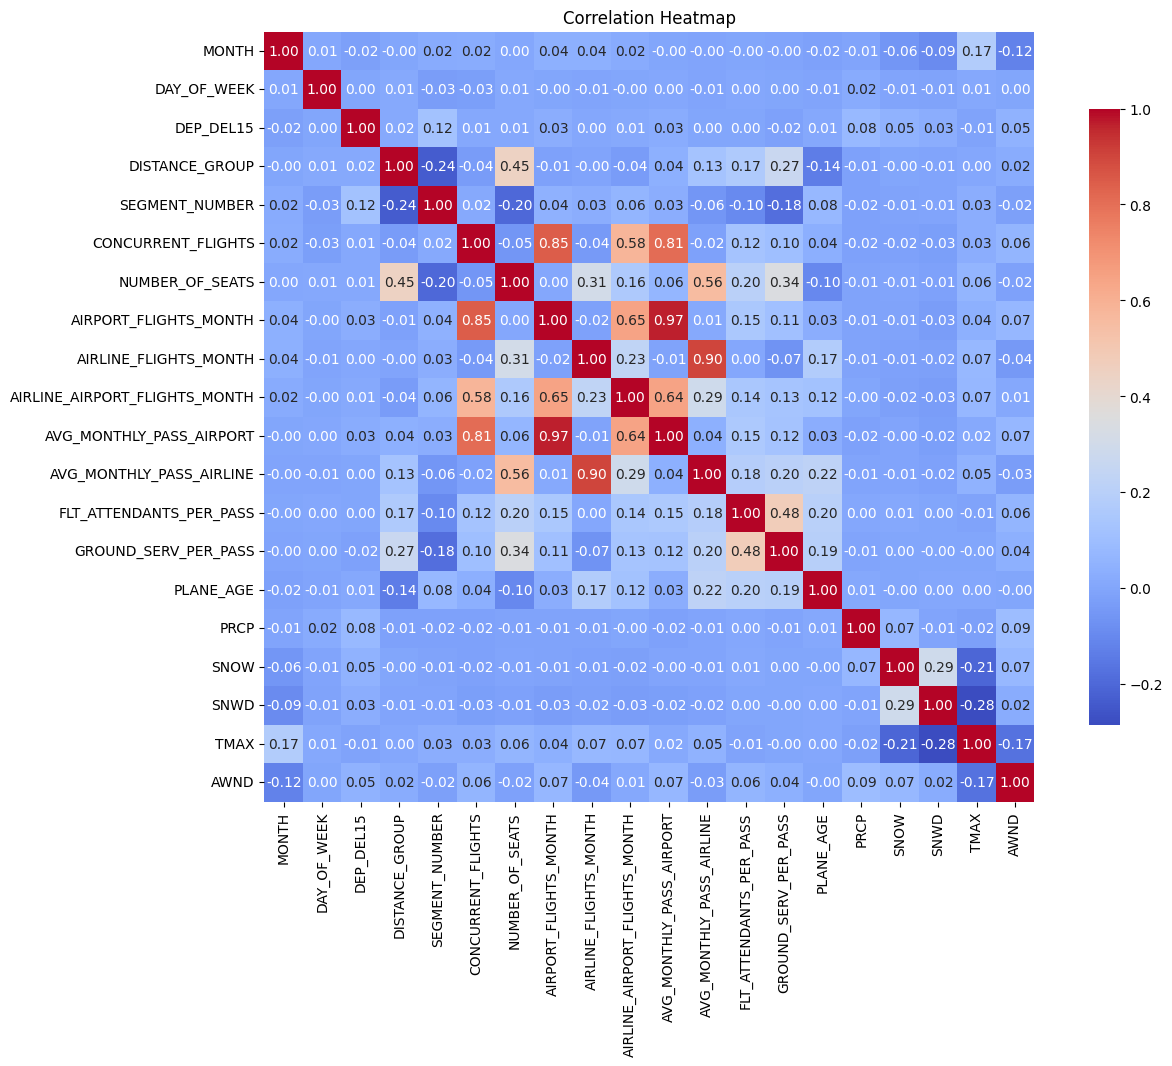

In [11]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(14, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap')
plt.show()

#### Visualizing Distributions of Numeric Features
We create histograms for all numeric columns in the dataset using `hist()`, with 30 bins for better granularity. The `figsize` parameter ensures that the plots are large enough for clear visibility. This visualization helps us understand the distribution of each numeric feature, identifying skewness, peaks, and potential outliers.


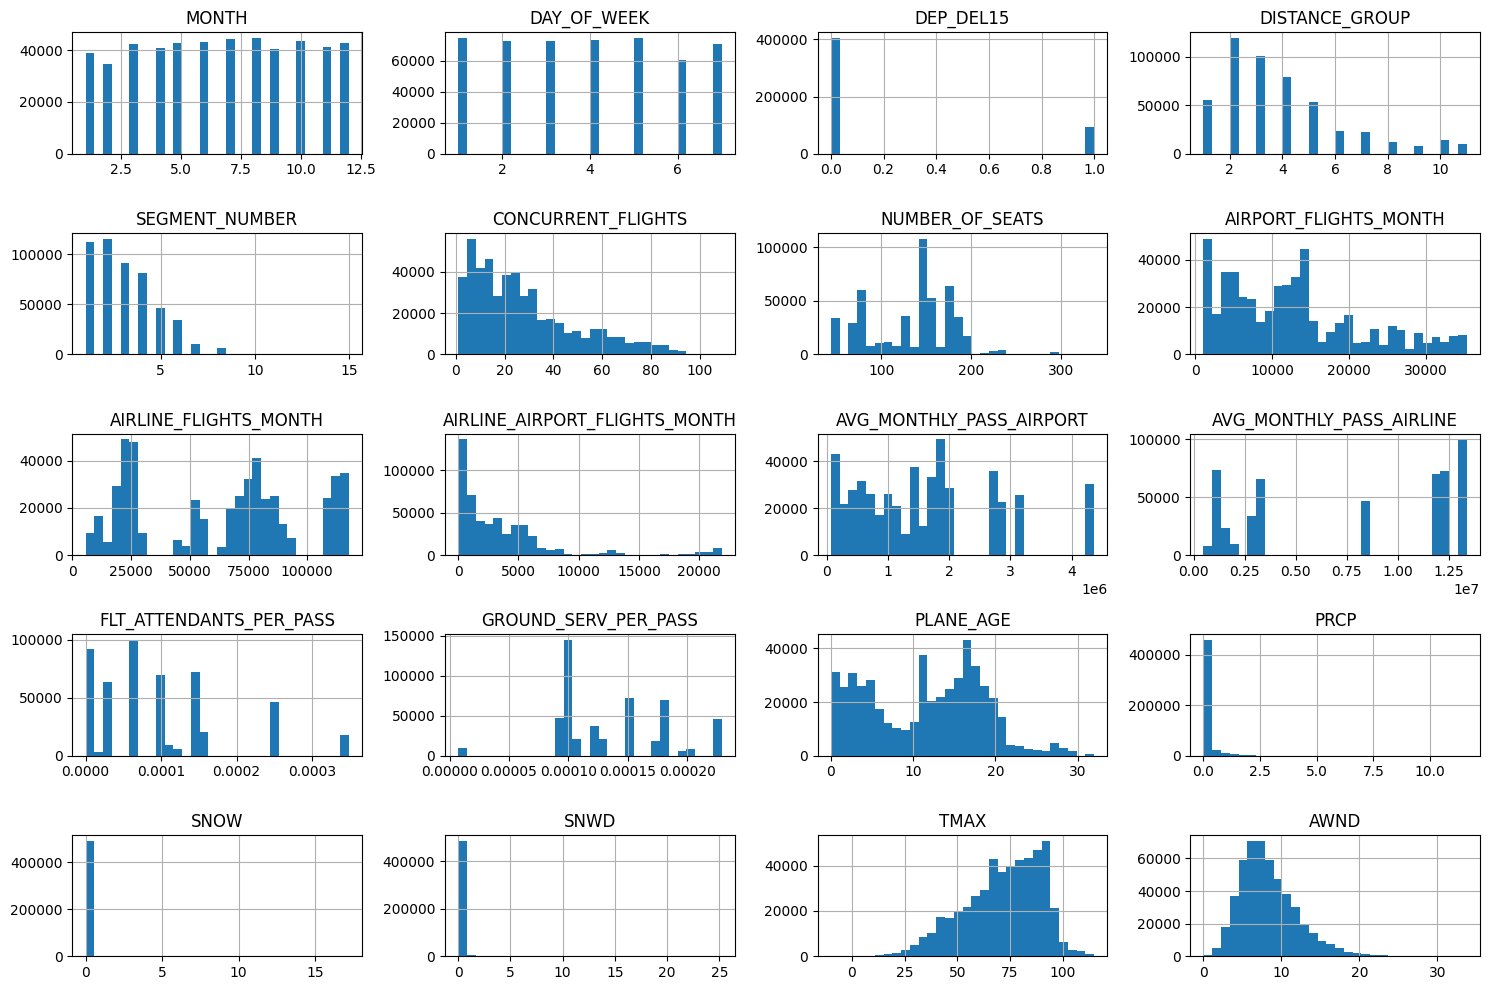

In [12]:
data[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

#### Number of Flights per Month for Each Departing Airport
We create a bar plot to visualize the number of flights per month for each departing airport. The `barplot()` function from Seaborn is used, with `AIRPORT_FLIGHTS_MONTH` on the x-axis and `DEPARTING_AIRPORT` on the y-axis. The `figsize` parameter adjusts the size of the figure for better readability.

This visualization helps us compare the volume of flights across different airports, providing insights into airport activity and traffic patterns.


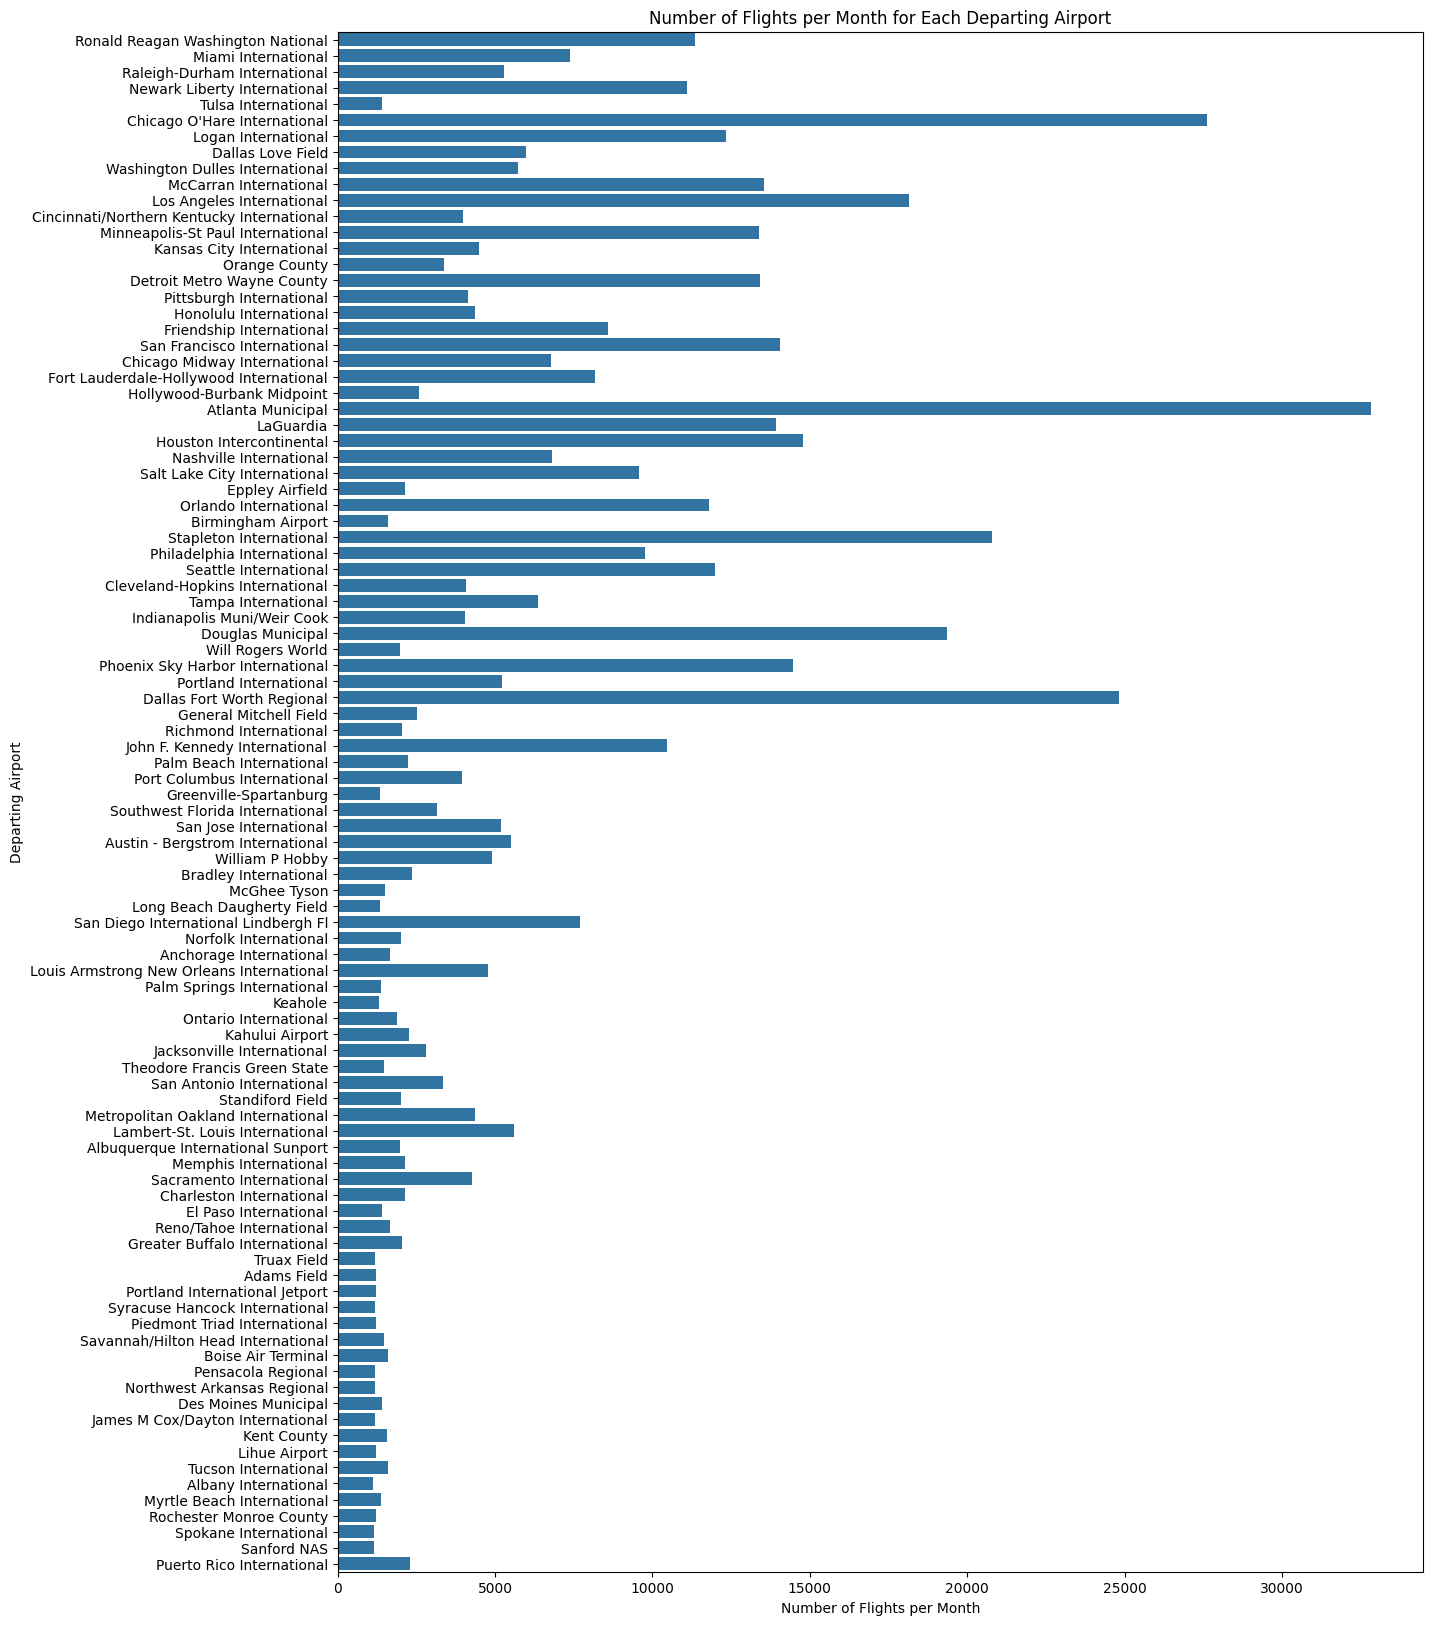

In [13]:
plt.figure(figsize=(14, 20))
sns.barplot(x='AIRPORT_FLIGHTS_MONTH', y='DEPARTING_AIRPORT', data=data, errorbar=None)
plt.title('Number of Flights per Month for Each Departing Airport')
plt.xlabel('Number of Flights per Month')
plt.ylabel('Departing Airport')
plt.show()

#### Categorizing Departure Times
We define time blocks to categorize departure times into different parts of the day: 'Early Morning & Late Night', 'Morning', 'Afternoon', 'Evening', and 'Night'. 

Using `pd.cut()`, we map the departure time blocks (`DEP_TIME_BLK`) to these categories based on the hour of departure. The `map()` function extracts the starting hour from each time block, and the defined bins correspond to the categories.

Finally, we display the first few rows of the `DEP_TIME_BLK` and the new `PART_OF_DAY` column to confirm the categorization.


In [14]:
time_blocks_order = [
    'Early Morning & Late Night',  # 0001-0559
    'Morning',                     # 0600-1159
    'Afternoon',                   # 1200-1659
    'Evening',                     # 1700-1959
    'Night'                        # 2000-2359
]

data['PART_OF_DAY'] = pd.cut(
    data['DEP_TIME_BLK'].map(lambda x: int(x.split('-')[0])),
    bins=[0, 600, 1200, 1700, 2000, 2400],
    labels=time_blocks_order,
    right=False
)

data[["DEP_TIME_BLK", "PART_OF_DAY"]].head()

,DEP_TIME_BLK,PART_OF_DAY
0,1500-1559,Afternoon
1,2200-2259,Night
2,1900-1959,Evening
3,1700-1759,Evening
4,0800-0859,Morning


#### Function to Calculate Midpoint of Time Ranges
We define a function `time_range_to_midpoint` that takes a time range (formatted as 'HH:MM-HH:MM') as input. The function splits the time range into its start and end times, extracts the hour components, and calculates the midpoint hour by averaging the start and end hours. This midpoint can be useful for converting time ranges into a single numerical feature for analysis.


In [15]:
def time_range_to_midpoint(time_range):
    start, end = time_range.split('-')
    start_hour = int(start[:2])
    end_hour = int(end[:2])
    midpoint = (start_hour + end_hour) / 2
    return midpoint


#### Heatmap of Average Delay Rate by Time Part of Day and Day of Week
We create a pivot table `heatmap_data` to calculate the mean delay rate (`DEP_DEL15`) for each combination of part of the day and day of the week. The `aggfunc='mean'` parameter aggregates the data accordingly.

Using Seaborn's `heatmap()`, we visualize this pivot table with a custom color map ranging from green to red to indicate average delay rates. Annotations are included for clarity, and we adjust the figure size and labels for better readability.

This heatmap provides insights into how average delay rates vary by time of day and day of the week, highlighting patterns in flight performance.


C:\Users\lequa\AppData\Local\Temp\ipykernel_24888\3479323662.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(


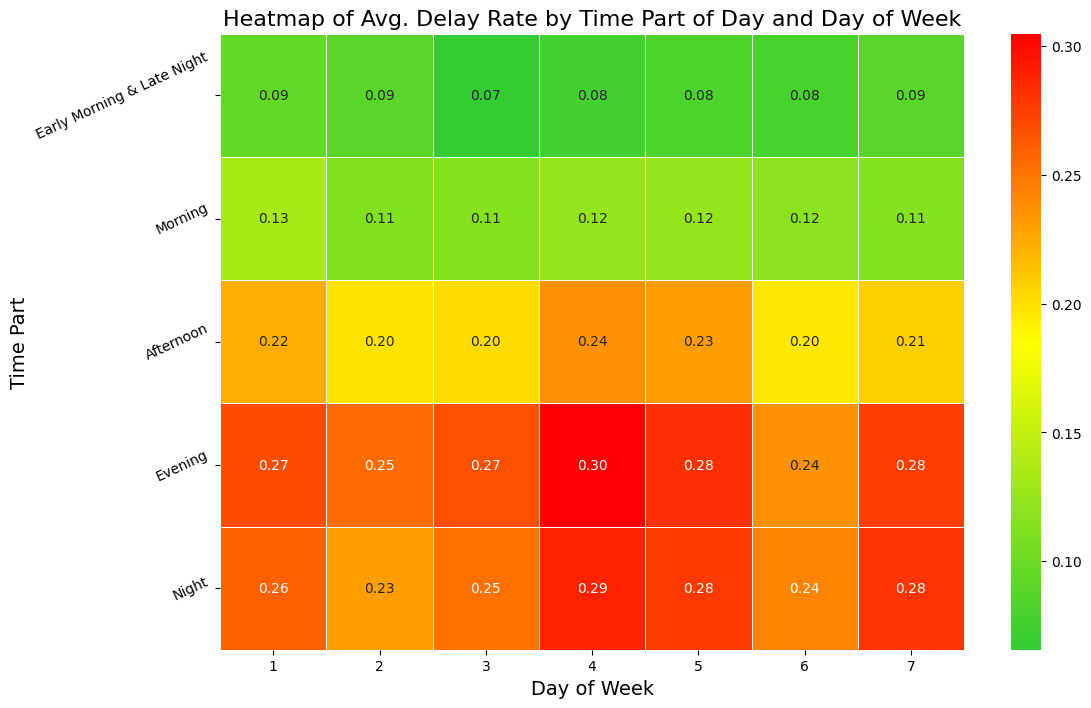

In [16]:
heatmap_data = pd.pivot_table(
    data,
    values='DEP_DEL15',
    index='PART_OF_DAY',
    columns='DAY_OF_WEEK',
    aggfunc='mean'
)

custom_cmap = LinearSegmentedColormap.from_list('custom', ['limegreen', 'yellow', 'red'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap=custom_cmap, fmt='.2f', linewidths=.5)

plt.title('Heatmap of Avg. Delay Rate by Time Part of Day and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Time Part', fontsize=14)
plt.yticks(rotation=25)
plt.show()

#### Max Temperature Across Months - Line Plot
We create a line plot to visualize the maximum temperature (`TMAX`) across different months. The x-axis represents the months, while the y-axis displays the maximum temperature in Fahrenheit. 

Using Seaborn's `lineplot()`, we include a hue based on the departure delay indicator (`DEP_DEL15`), with different colors for delayed (red) and on-time (lime) flights. Markers are added for better visibility, and we set `linewidth` to enhance line thickness.

This visualization allows us to observe trends in maximum temperatures across months and how they correlate with flight delays.


<Axes: title={'center': 'Max Tempartue Across Months - Line Plot'}, xlabel='Month', ylabel='Max Temparture (F)'>

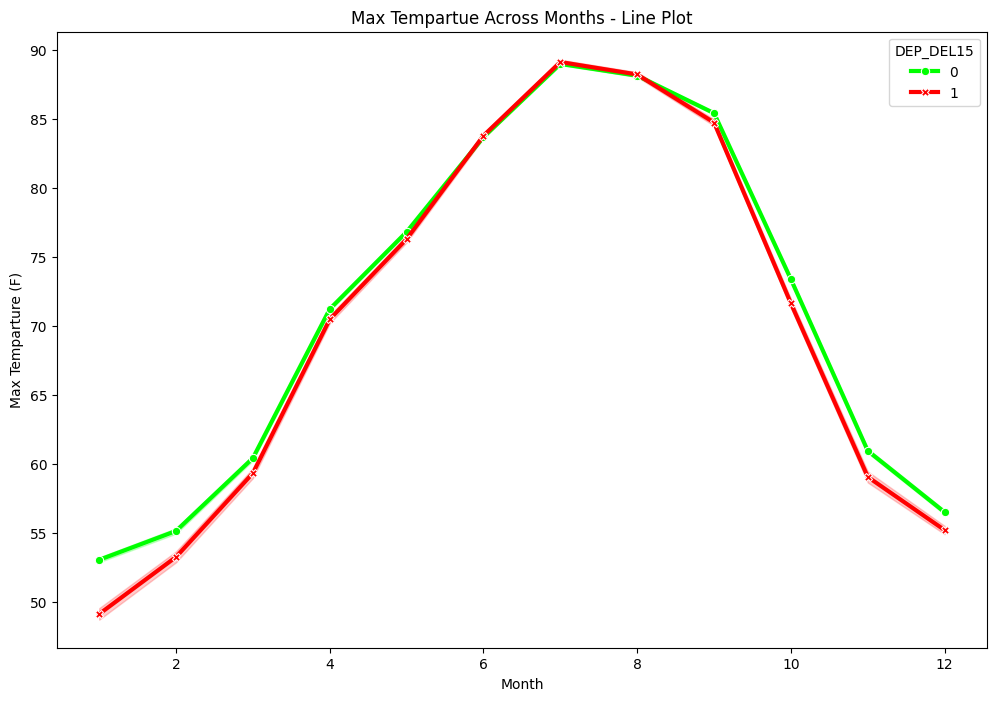

In [17]:
plt.figure(figsize=(12, 8))
plt.title("Max Tempartue Across Months - Line Plot")
plt.xlabel("Month")
plt.ylabel("Max Temparture (F)")
sns.lineplot(x = data.MONTH, y = data.TMAX, hue = data.DEP_DEL15, palette={0: 'lime', 1: 'red'}, style=data.DEP_DEL15, markers=True, dashes=False, linewidth = 3)

#### Flight Delays by Airline
The count plot visualizes the number of flights for each airline (`CARRIER_NAME`) based on their delay status (`DEP_DEL15`). The bars represent two categories: 
- **On-Time (0)** flights are indicated by blue bars.
- **Delayed (1)** flights are represented by orange bars.

This visualization helps in comparing the total number of flights between different airlines and highlights which airlines experience more delays. The x-axis lists the airlines, while the y-axis shows the number of flights. The plot also includes a legend for clarity, enhancing the understanding of the delay status for each airline.


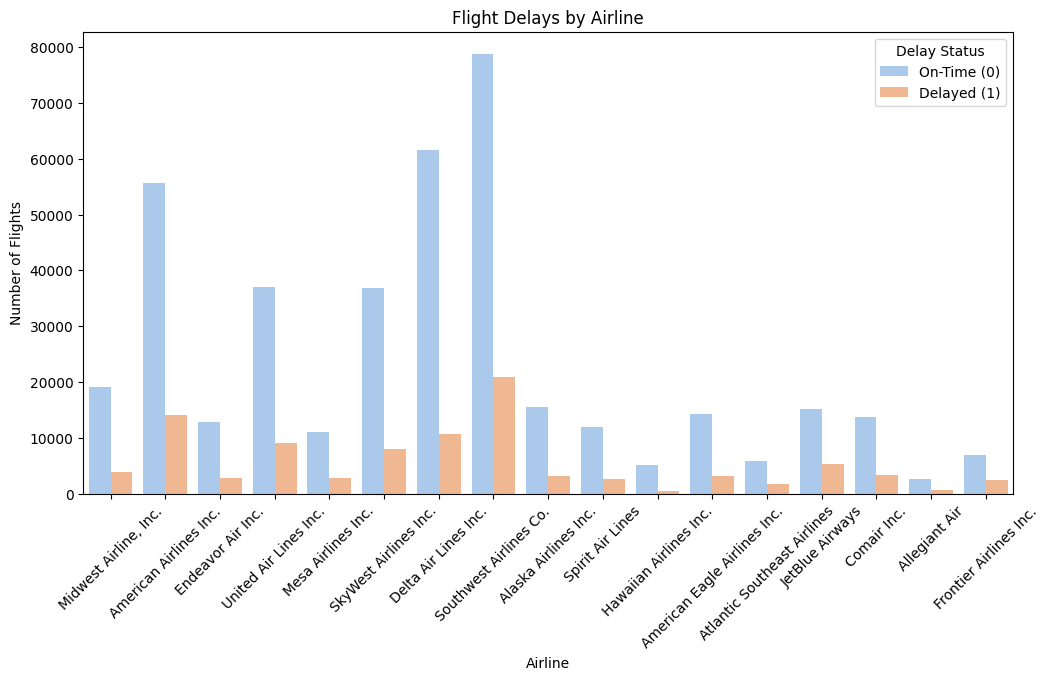

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(x='CARRIER_NAME', hue='DEP_DEL15', data=data, palette='pastel')
plt.title('Flight Delays by Airline')
plt.xticks(rotation=45)
plt.ylabel('Number of Flights')
plt.xlabel('Airline')
plt.legend(title='Delay Status', labels=['On-Time (0)', 'Delayed (1)'])
plt.show()

#### Average Flight Delay by Day of the Week - Bar Plot
We create a bar plot to visualize the average flight delay (`DEP_DEL15`) for each day of the week (`DAY_OF_WEEK`). The data is grouped by day, and the mean delay is calculated. 

Using Seaborn's `barplot()`, the plot shows the average delay for each day, with a color palette of 'viridis' for enhanced aesthetics. The x-axis is labeled with abbreviated day names (Mon, Tue, Wed, Thu, Fri, Sat, Sun), while the y-axis represents the average delay in minutes. 

This visualization allows us to easily compare average delays across the week, highlighting patterns in flight performance relative to different days.


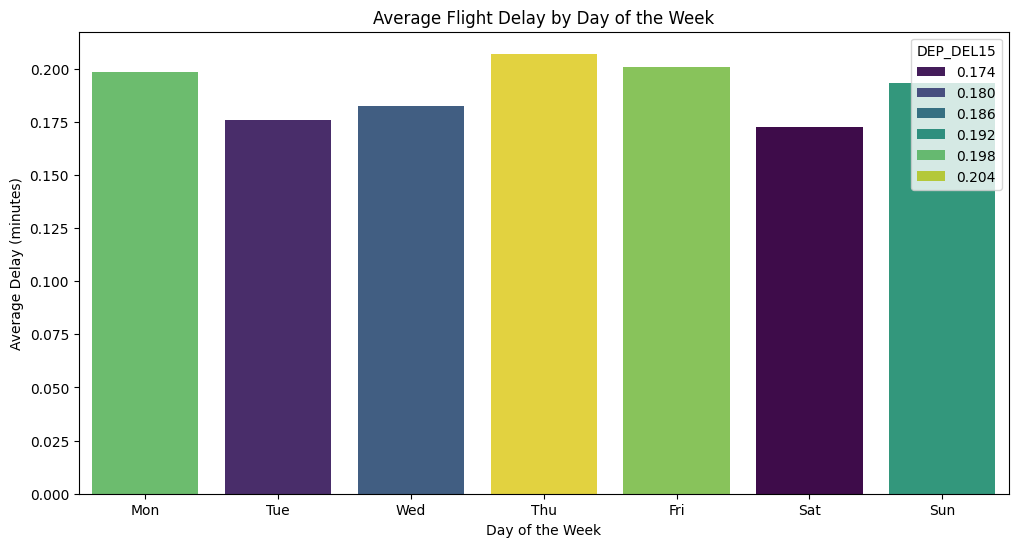

In [19]:
avg_delay_by_day = data.groupby('DAY_OF_WEEK')['DEP_DEL15'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='DAY_OF_WEEK', y='DEP_DEL15', data=avg_delay_by_day, palette='viridis', hue='DEP_DEL15')
plt.title('Average Flight Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

#### Average Flight Delay by Month - Line Plot
We create a line plot to visualize the average flight delay (`DEP_DEL15`) for each month of the year (`MONTH`). The data is grouped by month, and the mean delay is calculated.

Using Seaborn's `lineplot()`, we plot the average delays, with markers at each data point for clarity. The x-axis is labeled with abbreviated month names (Jan, Feb, Mar, etc.), while the y-axis represents the average delay in minutes. A grid is added to enhance readability.

This visualization allows us to observe trends in average flight delays across different months, helping to identify any seasonal patterns or variations in flight performance.


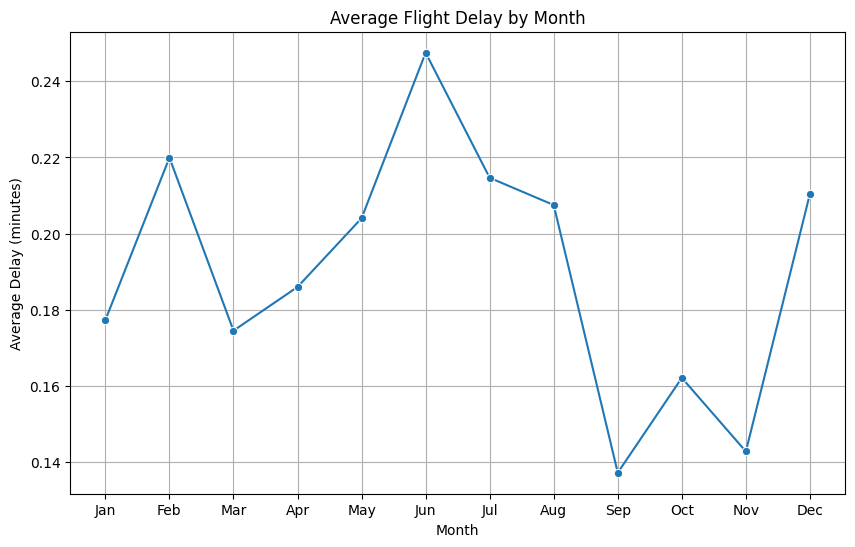

In [20]:
avg_delay_by_month = data.groupby('MONTH')['DEP_DEL15'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='MONTH', y='DEP_DEL15', data=avg_delay_by_month, marker='o')
plt.title('Average Flight Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

#### Proportion of Delayed vs. Non-Delayed Flights - Pie Chart
We create a pie chart to visualize the proportion of delayed flights (`DEP_DEL15`) compared to on-time flights. The chart displays two categories:
- **On Time** (represented in green)
- **Delayed** (represented in red)

Using the `value_counts()` method, we calculate the counts for each delay status, and the pie chart is configured to show percentage labels with one decimal place. The chart starts at a 90-degree angle to enhance visual clarity, and we ensure the pie is drawn as a circle with `plt.axis('equal')`.

This visualization provides a clear overview of the overall flight performance, highlighting the balance between delayed and on-time flights in the dataset.


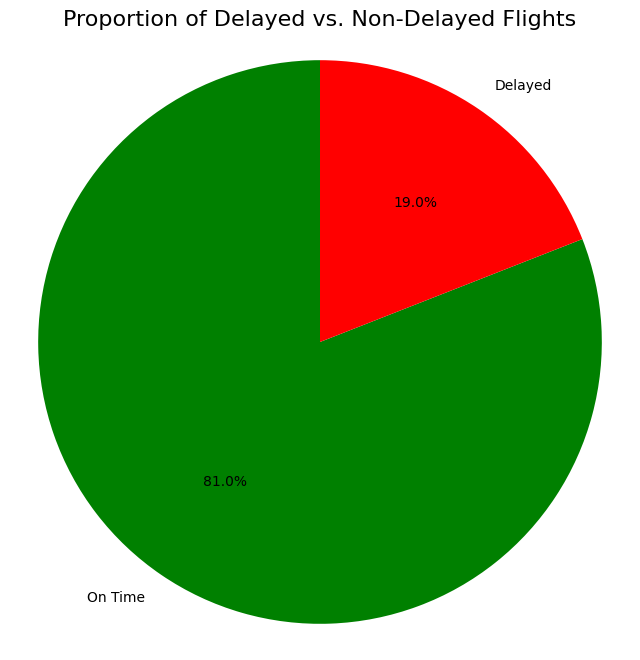

In [21]:
plt.figure(figsize=(8, 8))
plt.pie(data['DEP_DEL15'].value_counts(), labels=['On Time', 'Delayed'], autopct='%1.1f%%', startangle=90, colors=['green', 'red'])

plt.title('Proportion of Delayed vs. Non-Delayed Flights', fontsize=16)
plt.axis('equal')

plt.show()

#### Wind Speed Distribution by Departure Delay - KDE Plot
We create a Kernel Density Estimate (KDE) plot to visualize the distribution of wind speed (`AWND`) for flights categorized by their delay status (`DEP_DEL15`). The data is split into two classes:
- **On-Time Flights (False)**: represented by the green area.
- **Delayed Flights (True)**: represented by the red area.

The plot overlays the density curves for each class, allowing us to compare their distributions visually. Vertical dashed lines indicate the mean wind speed for each class, helping to identify differences in average wind speed between on-time and delayed flights.

This visualization aids in understanding how wind speed may influence flight delays, providing insights into potential factors affecting airline performance.


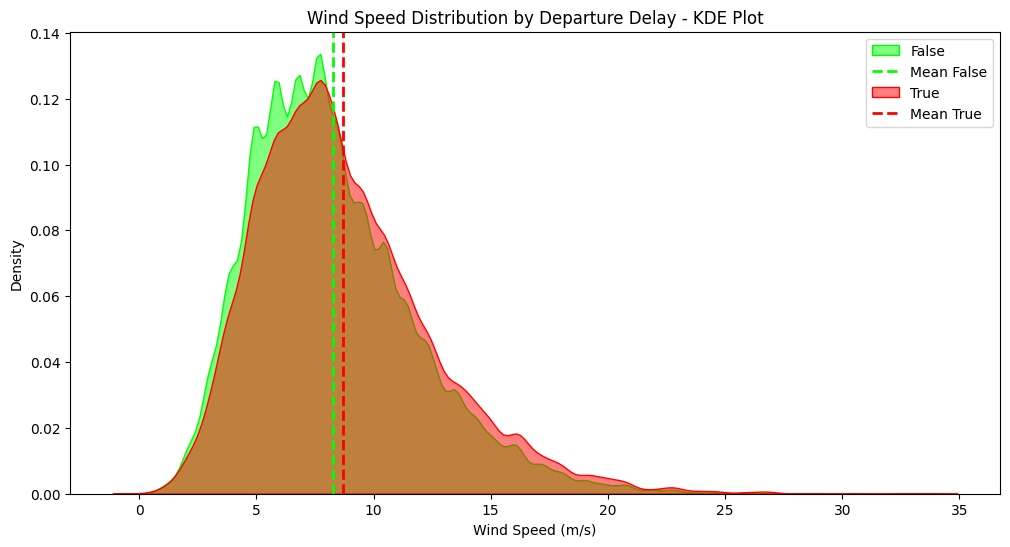

In [22]:
data_class0 = data[data['DEP_DEL15'] == 0]['AWND']
data_class1 = data[data['DEP_DEL15'] == 1]['AWND']
plt.figure(figsize=(12, 6))

sns.kdeplot(data_class0, color='lime', label='False', alpha=0.5, fill = True)
plt.axvline(data_class0.mean(), color='lime', linestyle='--', linewidth=2, label='Mean False')
sns.kdeplot(data_class1, color='red', label='True', alpha=0.5, fill = True)
plt.axvline(data_class1.mean(), color='red', linestyle='--', linewidth=2, label='Mean True')


plt.legend()
plt.title('Wind Speed Distribution by Departure Delay - KDE Plot')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.show()

#### Histogram of Precipitation for Delayed and Non-Delayed Flights
We create a histogram to visualize the distribution of precipitation (`PRCP`) for flights based on their delay status (`DEP_DEL15`). The dataset is divided into two groups:
- **Delayed Flights**: represented in red.
- **Not Delayed Flights**: represented in lime.

Using `sns.histplot()`, we plot the density of precipitation for both classes. The histogram is set to a logarithmic scale for the y-axis to better display the distribution of data, particularly for lower precipitation values. The bins are set to 40 for finer granularity.

This visualization allows us to compare the precipitation levels associated with delayed and on-time flights, providing insights into how weather conditions may affect flight performance.


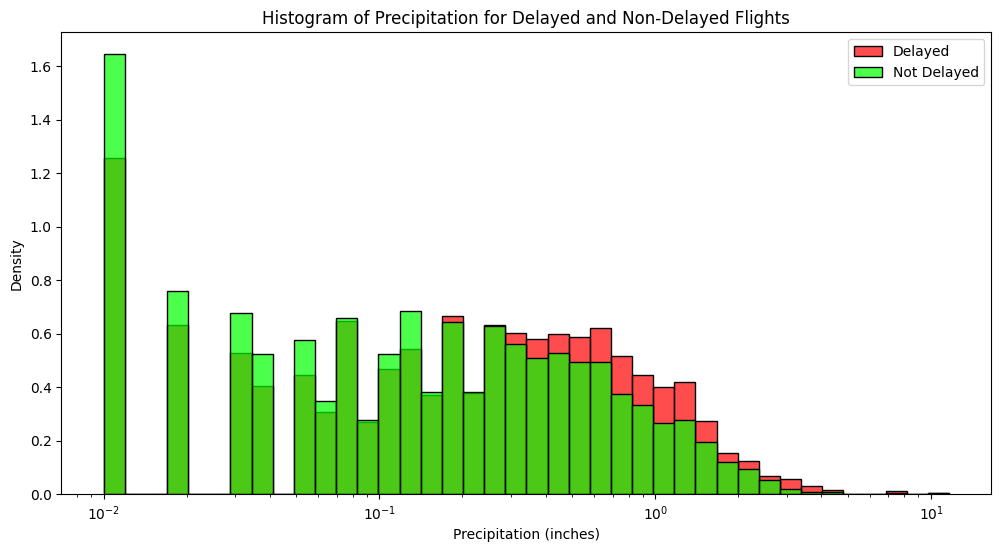

In [41]:
plt.figure(figsize=(12, 6))
df_delayed = data[data['DEP_DEL15'] == 1]
df_not_delayed = data[data['DEP_DEL15'] == 0]
sns.histplot(df_delayed['PRCP'], color='red', label='Delayed', stat="density", bins=40, alpha=0.7, log_scale = True)
sns.histplot(df_not_delayed['PRCP'], color='lime', label='Not Delayed', stat="density", bins=40, alpha=0.7, log_scale = True)
plt.title('Histogram of Precipitation for Delayed and Non-Delayed Flights')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Mapping Time Blocks to Numerical Values
In this section, we create a dictionary called `block_num` to assign numerical values to different parts of the day. The mapping is as follows:
- **Early Morning & Late Night**: 1
- **Morning**: 2
- **Afternoon**: 3
- **Evening**: 4
- **Night**: 5

We then apply this mapping to the `PART_OF_DAY` column in the dataset using the `map()` function, transforming categorical time blocks into their corresponding numerical values. This step is essential for facilitating numerical analysis and modeling.

Finally, we display the first few rows of the `DEP_TIME_BLK` and the newly mapped `PART_OF_DAY` columns to verify the transformation.


In [24]:
block_num = {
    'Early Morning & Late Night': 1,
    'Morning' : 2,
    'Afternoon' : 3,
    'Evening' : 4,
    'Night' : 5
}
data['PART_OF_DAY'] = data['PART_OF_DAY'].map(block_num)
data[['DEP_TIME_BLK' ,'PART_OF_DAY']].head()

,DEP_TIME_BLK,PART_OF_DAY
0,1500-1559,3
1,2200-2259,5
2,1900-1959,4
3,1700-1759,4
4,0800-0859,2


#### Preparing Data for Model Training and Testing
In this section, we prepare the feature matrix `X` and the target variable `y` for our predictive model. The features selected for the model include:
- **PRCP**: Precipitation (inches)
- **AWND**: Average wind speed (m/s)
- **SNOW**: Snowfall (inches)
- **SNWD**: Snow depth (inches)
- **SEGMENT_NUMBER**: The segment number of the flight
- **PART_OF_DAY**: The numerical representation of the part of the day

We convert both the features and the target variable into NumPy arrays for efficient processing.

Next, we split the dataset into training and testing sets using `train_test_split()`, with 80% of the data used for training and 20% reserved for testing. The `random_state` parameter is set to 42 to ensure reproducibility of the results.

This preparation step is crucial for building and evaluating the performance of our machine learning models.


In [25]:
X = data[["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "PART_OF_DAY"]].to_numpy()
    
y = data["DEP_DEL15"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scaling the Features
In this section, we standardize the feature data to ensure that all input variables are on a similar scale, which can improve the performance and convergence speed of many machine learning algorithms.

1. We initialize a `StandardScaler` instance.
2. The `fit_transform()` method is applied to the training set `X_train` to compute the mean and standard deviation, and then scale the data accordingly. This results in `X_train_scaled`.
3. The `transform()` method is then used on the testing set `X_test` to apply the same scaling parameters obtained from the training data, resulting in `X_test_scaled`.

By scaling the features, we ensure that each feature contributes equally to the model's learning process, reducing the risk of bias due to differing magnitudes of feature values.


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale training data
X_test_scaled = scaler.transform(X_test)  # Scale testing data

#### Training the Random Forest Classifier
In this section, we initialize a Random Forest classifier with a fixed `random_state` of 42 to ensure reproducibility. 

1. We create an instance of `RandomForestClassifier` called `rf_model`.
2. The model is then trained using the scaled training data (`X_train_scaled`) and the target variable (`y_train`) by calling the `fit()` method.

After the model has been trained, we proceed to make predictions on the test dataset:
- We use the `predict()` method on the scaled test data (`X_test_scaled`) to generate predictions, which are stored in the variable `y_pred_rf`.

This step is essential for evaluating the model's performance on unseen data, providing insights into its predictive capabilities.


In [27]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_scaled)

#### Training the Gradient Boosting Classifier
In this section, we initialize a Gradient Boosting classifier with a fixed `random_state` of 42 for reproducibility.

1. We create an instance of `GradientBoostingClassifier` called `gb_model`.
2. The model is trained using the scaled training data (`X_train_scaled`) and the target variable (`y_train`) by calling the `fit()` method.

After the model has been trained, we proceed to make predictions on the test dataset:
- We utilize the `predict()` method on the scaled test data (`X_test_scaled`) to generate predictions, which are stored in the variable `y_pred_gb`.

This step allows us to assess the performance of the Gradient Boosting model on unseen data, helping to understand its effectiveness in predicting flight delays.


In [28]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_gb = gb_model.predict(X_test_scaled)

#### Training the Logistic Regression Model
In this section, we initialize a Logistic Regression model with a fixed `random_state` of 42 to ensure reproducibility.

1. We create an instance of `LogisticRegression` called `log_reg_model`.
2. The model is trained using the original training data (`X_train`) and the target variable (`y_train`) by calling the `fit()` method.

After training the model, we make predictions on the test dataset:
- We use the `predict()` method on the original test data (`X_test`) to generate predictions, which are stored in the variable `y_pred_log_reg`.

This step allows us to evaluate the performance of the Logistic Regression model on unseen data, providing insights into its predictive accuracy for flight delays.


In [29]:
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_log_reg = log_reg_model.predict(X_test)


#### Model Evaluation
In this section, we evaluate the performance of three different models: Random Forest, Gradient Boosting, and Logistic Regression. The evaluation metrics used include accuracy, F1 score, confusion matrix, and classification report.

1. **Random Forest Model Evaluation**:
   - We calculate and print the accuracy score using `accuracy_score()`.
   - The F1 score is calculated using `f1_score()`, which balances precision and recall.
   - We display the confusion matrix using `confusion_matrix()`, providing insights into the model's true positives, false positives, true negatives, and false negatives.
   - A comprehensive classification report is generated using `classification_report()`, which includes precision, recall, and F1 scores for each class.

2. **Gradient Boosting Model Evaluation**:
   - Similar evaluation metrics are calculated and printed for the Gradient Boosting model.

3. **Logistic Regression Model Evaluation**:
   - We compute the accuracy, confusion matrix, and classification report for the Logistic Regression model, presenting the results in a structured format.

These evaluation metrics provide a thorough understanding of each model's performance, enabling us to compare their effectiveness in predicting flight delays.


In [30]:
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Evaluation:
Accuracy: 0.8049439281319715
F1 Score: 0.19469684453989758

Confusion Matrix:
 [[78106  2923]
 [16575  2357]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89     81029
           1       0.45      0.12      0.19     18932

    accuracy                           0.80     99961
   macro avg       0.64      0.54      0.54     99961
weighted avg       0.75      0.80      0.76     99961



In [31]:
print("\nGradient Boosting Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Model Evaluation:
Accuracy: 0.8125468932883825
F1 Score: 0.05592503022974607

Confusion Matrix:
 [[80668   361]
 [18377   555]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     81029
           1       0.61      0.03      0.06     18932

    accuracy                           0.81     99961
   macro avg       0.71      0.51      0.48     99961
weighted avg       0.77      0.81      0.74     99961



In [44]:
accuracy = accuracy_score(y_test, y_pred_log_reg)
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
class_report = classification_report(y_test, y_pred_log_reg)

# Print the evaluation results
print("\nLogicstic Regression Model Evaluation:")
print("F1 Score:", f1_score(y_test, y_pred_log_reg))
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Logicstic Regression Model Evaluation:
F1 Score: 0.019285603193529992
Accuracy: 0.8107561949160172

Confusion Matrix:
 [[80858   171]
 [18746   186]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     81029
           1       0.52      0.01      0.02     18932

    accuracy                           0.81     99961
   macro avg       0.67      0.50      0.46     99961
weighted avg       0.76      0.81      0.73     99961



#### Additional Model Evaluation Metrics
In this section, we compute and display additional evaluation metrics for the Random Forest, Gradient Boosting, and Logistic Regression models, focusing on regression performance.

1. **Mean Squared Error (MSE)**: This metric quantifies the average squared difference between the predicted and actual values. A lower MSE indicates better model performance.

2. **Mean Absolute Error (MAE)**: This metric represents the average absolute difference between the predicted and actual values, providing a linear score that is easier to interpret.

3. **Root Mean Squared Error (RMSE)**: This is the square root of the MSE, providing an error metric in the same units as the target variable, making it more interpretable.

4. **R² Score**: This metric indicates the proportion of variance in the target variable that can be explained by the model. An R² score close to 1 suggests a good fit.

For each model, we calculate and print these metrics:
- Random Forest Model
- Gradient Boosting Model
- Logistic Regression Model

These metrics give us a comprehensive understanding of each model's performance, particularly in terms of prediction accuracy and error quantification.


In [33]:
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.1951
Mean Absolute Error (MAE): 0.1951
Root Mean Squared Error (RMSE): 0.4417
R² Score: -0.2705


c:\Users\lequa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
mse = mean_squared_error(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
rmse = mean_squared_error(y_test, y_pred_gb, squared=False)
r2 = r2_score(y_test, y_pred_gb)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.1875
Mean Absolute Error (MAE): 0.1875
Root Mean Squared Error (RMSE): 0.4330
R² Score: -0.2210


c:\Users\lequa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
mse = mean_squared_error(y_test, y_pred_log_reg)
mae = mean_absolute_error(y_test, y_pred_log_reg)
rmse = mean_squared_error(y_test, y_pred_log_reg, squared=False)
r2 = r2_score(y_test, y_pred_log_reg)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.1892
Mean Absolute Error (MAE): 0.1892
Root Mean Squared Error (RMSE): 0.4350
R² Score: -0.2327


c:\Users\lequa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Receiver Operating Characteristic (ROC) Curve Analysis
In this section, we analyze the performance of the Random Forest, Gradient Boosting, and Logistic Regression models using the Receiver Operating Characteristic (ROC) curve.

1. **ROC Curve**: The ROC curve illustrates the trade-off between the true positive rate (TPR) and the false positive rate (FPR) for different threshold values. A model that perfectly classifies the data would achieve a TPR of 1 and an FPR of 0.

2. **Area Under the Curve (AUC)**: The AUC score quantifies the overall performance of the model. An AUC of 1 indicates perfect classification, while an AUC of 0.5 suggests no discriminative power.

In this implementation:
- We calculate the FPR and TPR for each model using `roc_curve()` based on the predicted probabilities of the positive class.
- The AUC for each model is computed using `auc()`.

Finally, we plot the ROC curves:
- The Random Forest curve is shown in dark orange.
- The Gradient Boosting curve is shown in blue.
- The Logistic Regression curve is shown in green.
- A dashed line represents the baseline (no discrimination).

This visualization provides insights into the relative performance of each model in distinguishing between delayed and non-delayed flights.


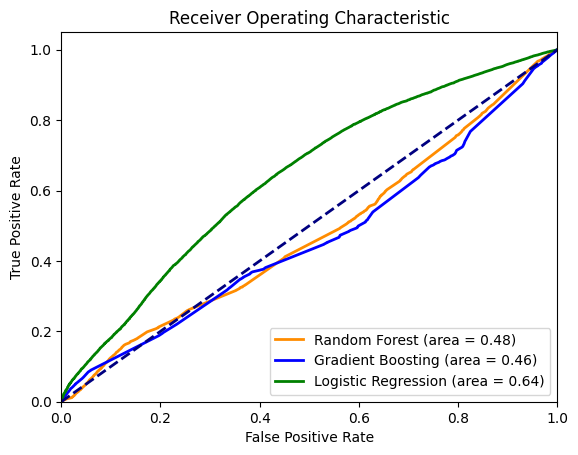

In [36]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
log_reg_roc_auc = auc(log_reg_fpr, log_reg_tpr)

# Existing code for Random Forest and Gradient Boosting
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
gb_roc_auc = auc(gb_fpr, gb_tpr)

# Plotting the ROC curves
plt.figure()
plt.plot(rf_fpr, rf_tpr, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label='Gradient Boosting (area = %0.2f)' % gb_roc_auc)
plt.plot(log_reg_fpr, log_reg_tpr, color='green', lw=2, label='Logistic Regression (area = %0.2f)' % log_reg_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Confusion Matrix Visualization
In this section, we visualize the confusion matrices for the Random Forest, Gradient Boosting, and Logistic Regression models to evaluate their classification performance.

1. **Confusion Matrix**: A confusion matrix is a table used to evaluate the performance of a classification model. It compares the actual target values with those predicted by the model, providing insight into true positive (TP), true negative (TN), false positive (FP), and false negative (FN) classifications.

2. **Heatmap Representation**: We use heatmaps to visualize the confusion matrices for each model, where:
   - Rows represent the true labels.
   - Columns represent the predicted labels.
   - Each cell in the matrix indicates the count of predictions for each category.

In this implementation:
- We compute the confusion matrix using `confusion_matrix()` for each model and visualize it using Seaborn's `heatmap()`.
- The color intensity indicates the number of observations in each category, with annotations displaying the exact counts.

This visualization helps in assessing the models' strengths and weaknesses in correctly classifying the instances of delayed and non-delayed flights.


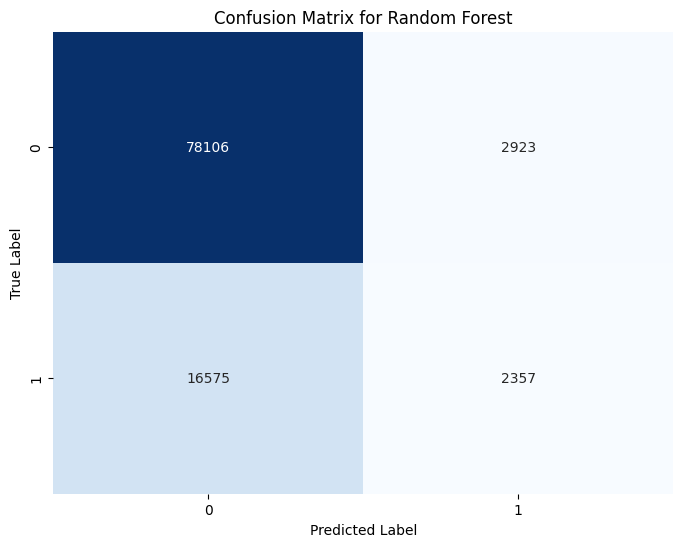

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

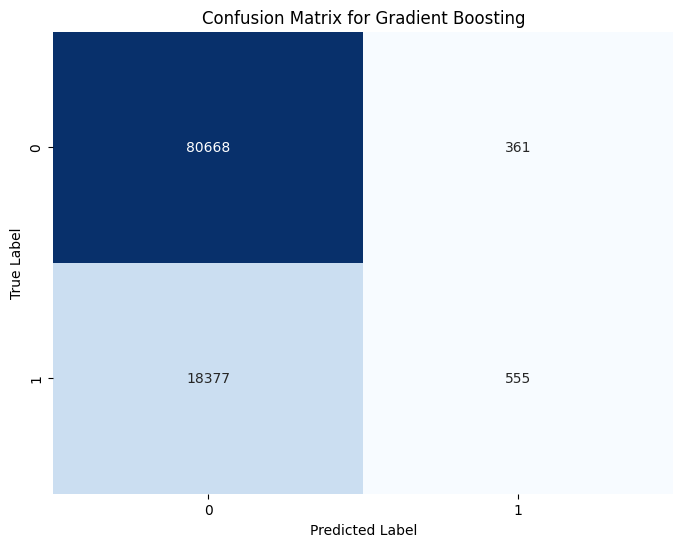

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

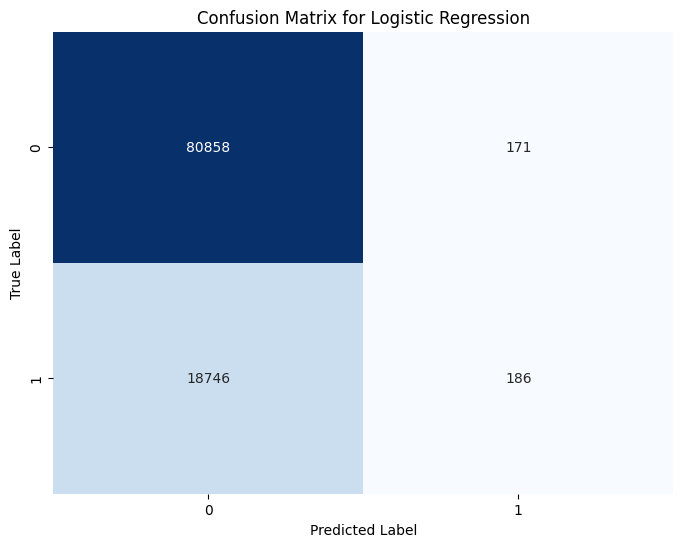

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Feature Importances from Random Forest Model
In this section, we analyze the importance of each feature used in the Random Forest model. Understanding feature importance helps us identify which factors have the most influence on predicting flight delays.

1. **Feature Importance**: Feature importance indicates how useful each feature is in making predictions. Higher importance values suggest that a feature significantly contributes to the model's predictions.

2. **Visualization**: We visualize the feature importances using a bar plot:
   - The bars represent the importance score of each feature, sorted in descending order.
   - The x-axis shows the features, while the y-axis displays their respective importance scores.

In this implementation:
- We extract the feature importances using `rf_model.feature_importances_`.
- The indices of the sorted importances are calculated and used to reorder the features for visualization.

This visualization provides insights into which weather-related factors and operational characteristics are most predictive of flight delays, aiding in decision-making and further analysis.


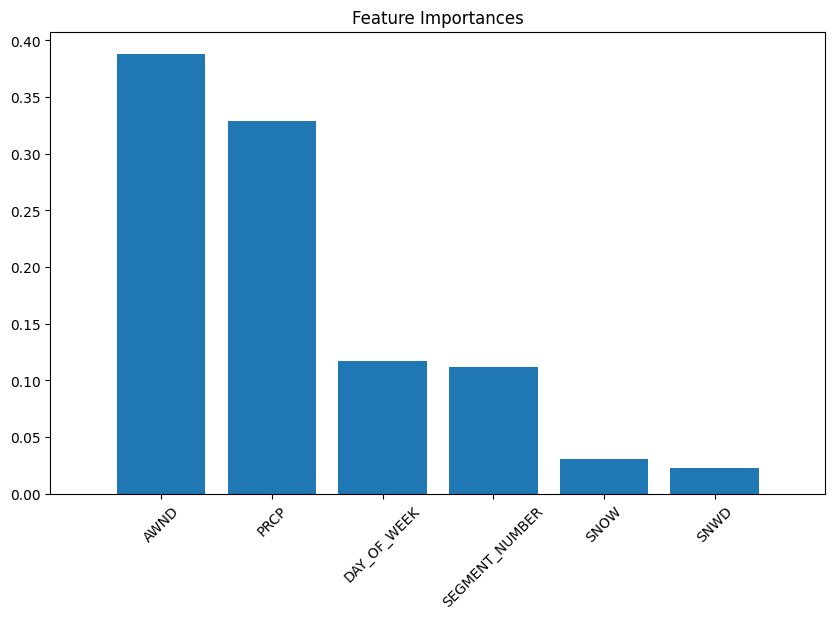

In [40]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "DAY_OF_WEEK"])[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()